Ongoing notes

- Legacy PQ uses sea water & saturation, currently not doing that for collection upgrade
- Probably need buffer on terrain tile

## Load required data

In [40]:
import datacube
import sys

sys.path.append('../../code/dea-notebooks/10_Scripts')
import DEAPlotting, SpatialTools

sys.path.insert(0,'/g/data/u46/users/bt2744/work/code/wofs-prods/wofs/') # to import wofs (and preferentially from here)
import wofs.wofs_app

import numpy as np
import scipy
import xarray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from datacube.storage import masking

from functools import reduce


In [3]:
# %load_ext autoreload
# %autoreload 2

In [2]:
dc_up = datacube.Datacube(env="ard_interop")
dc_w = datacube.Datacube(env="wofsanc")
dc_prod = datacube.Datacube()

In [3]:
# centre point of query
lat, lon = -19.25, 146.75
time_period = ('2017-01-15', '2017-01-21')

# Bands/measurements to load
wofs_measurements = ['nbart_red', 'nbart_blue', 'nbart_green', 'nbart_nir', 
                    'nbart_swir_1', 'nbart_swir_2', 'fmask', 'terrain_shadow', 
                     'nbart_contiguity']

# Size of area
buff = 0.05
c_align = (30/2.0, 30/2.0)

# Set up query
query = {'lon': (lon - buff, lon + buff),
         'lat': (lat - buff, lat + buff),
         'gqa_iterative_mean_xy':[0, 1],
         'time': time_period}

datasets = dc_up.find_datasets(product='ls8_ard', **query)

## TEST dataset
dataset = datasets[0]

# Output resolution and projection
output_resolution = (30, 30)
output_crs = dataset.crs.crs_str

In [4]:
ds = dc_up.load(product='ls8_ard', 
                  #measurements=wofs_measurements, 
                  output_crs=output_crs,
                  resolution=output_resolution, 
                  #dask_chunks={'time':1},
                  **query, #datasets=[dataset],
                  align=c_align
                 )
ds = ds.squeeze()
#ds

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)


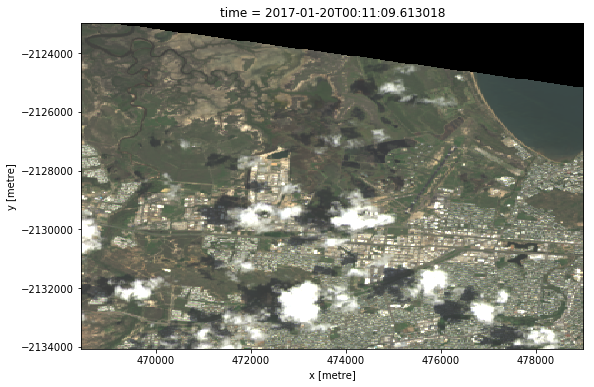

In [6]:
DEAPlotting.rgb(ds, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

## Classify

In [7]:
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
water = wofs.classifier.classify(ds[bands].to_array(dim='band'))

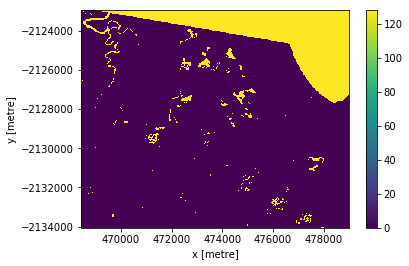

In [8]:
water.plot.imshow();

## Filter

In [9]:
# For the following bits, 0=unmasked
WATER_PRESENT = 1 << 7   # (dec 128) bit 7: 1=water present, 0=no water if all other bits zero
MASKED_CLOUD = 1 << 6   # (dec 64)  bit 6: 1=pixel masked out due to cloud
MASKED_CLOUD_SHADOW = 1 << 5   # (dec 32)  bit 5: 1=pixel masked out due to cloud shadow
MASKED_HIGH_SLOPE = 1 << 4   # (dec 16)  bit 4: 1=pixel masked out due to high slope
MASKED_TERRAIN_SHADOW = 1 << 3  # (dec 8)   bit 3: 1=pixel masked out due to terrain shadow or
#                                                    low solar incidence angle,
MASKED_SEA_WATER = 1 << 2   # (dec 4)   bit 2: 1=pixel masked out due to being over sea
MASKED_NO_CONTIGUITY = 1 << 1   # (dec 2)   bit 1: 1=pixel masked out due to lack of data contiguity
NO_DATA = 1 << 0   # (dec 1)   bit 0: 1=pixel masked out due to NO_DATA in NBAR source, 0=valid data in NBAR
WATER_NOT_PRESENT = 0        # (dec 0)          All bits zero indicated valid observation, no water present

# Water detected on slopes equal or greater than this value are masked out
SLOPE_THRESHOLD_DEGREES = 12.0

# If the sun only grazes a hillface, observation unreliable (vegetation shadows etc)
LOW_SOLAR_INCIDENCE_THRESHOLD_DEGREES = 30

### eo - No data / non-contiguous

In [10]:
def eo_filter(source):
    """
    Find where there is no data
    Input must be dataset, not array (since bands could have different nodata values).
    """
    nodata_bools = source.apply(lambda array: array == array.nodata).to_array(dim='band')

    nothingness = nodata_bools.all(dim='band')
    noncontiguous = nodata_bools.any(dim='band')

    return nothingness | noncontiguous


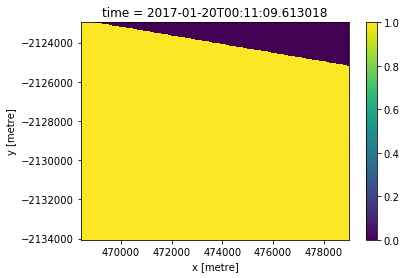

In [11]:
f1 = ~eo_filter(ds[bands])
f1.plot.imshow();

### PQ - cloud / cloud shadow / contiguity (again?) / sea water (not) / saturation

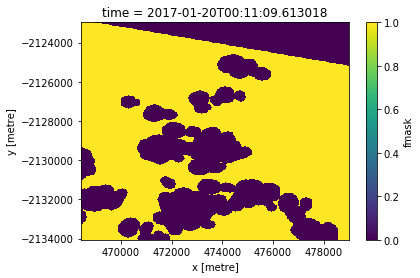

In [12]:
#fmask: null(0), cloud(2), cloud shadow(3)
f2 = ~(ds.fmask.isin([0,2,3]))
f2.plot.imshow();

### Terrain - shadow / high slope

In [13]:
def dilate(array):
    """Dilation e.g. for cloud and cloud/terrain shadow"""
    # kernel = [[1] * 7] * 7 # blocky 3-pixel dilation
    y, x = np.ogrid[-3:4, -3:4]
    kernel = ((x * x) + (y * y) <= 3.5**2)  # disk-like 3-pixel radial dilation
    return scipy.ndimage.binary_dilation(array, structure=kernel)


def terrain_filter(dsm, nbar):
    """
        Terrain shadow masking, slope masking, solar incidence angle masking.
        Input: xarray DataSets
    """

    shadows, slope, sia = wofs.terrain.shadows_and_slope(dsm, nbar.nbart_blue.time.values)

    shadowy = dilate(shadows != wofs.terrain.LIT) | (sia < LOW_SOLAR_INCIDENCE_THRESHOLD_DEGREES)

    steep = (slope > SLOPE_THRESHOLD_DEGREES)

    result = np.uint8(MASKED_TERRAIN_SHADOW) * shadowy | np.uint8(MASKED_HIGH_SLOPE) * steep

    return xarray.DataArray(result, coords=[dsm.y, dsm.x])  # note, assumes (y,x) axis ordering



In [14]:
x1=ds.x.data[0]
x2=ds.x.data[-1]
y1=ds.y.data[0]
y2=ds.y.data[-1]

dsm = dc_prod.load(product='dsm1sv10',
                   crs=output_crs,
                   output_crs=output_crs, 
                   resolution=output_resolution, 
                   align=c_align,
                   resampling='average',
                   x=(x1, x2),
                   y=(y1,y2) )
dsm = dsm.squeeze()

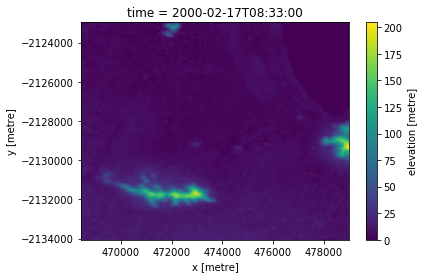

In [15]:
#dsm.elevation.where(~f1).plot()
dsm.elevation.plot.imshow();

#### Compare dsm calculated terrain shadow to terrain shadow band

In [16]:
tf = terrain_filter(dsm, ds)

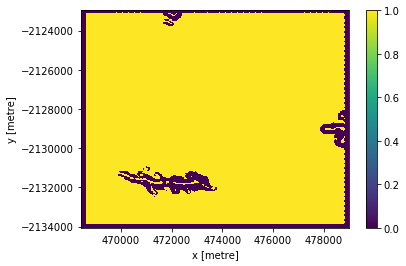

In [17]:
tf = (tf == 0)
tf.plot.imshow();

In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Apply Filters

In [18]:
#create good data mask
good_pixels = reduce(np.logical_and, [f1,f2,tf])

In [19]:
clear_water = water.where(good_pixels)
newWOFL = clear_water > 0

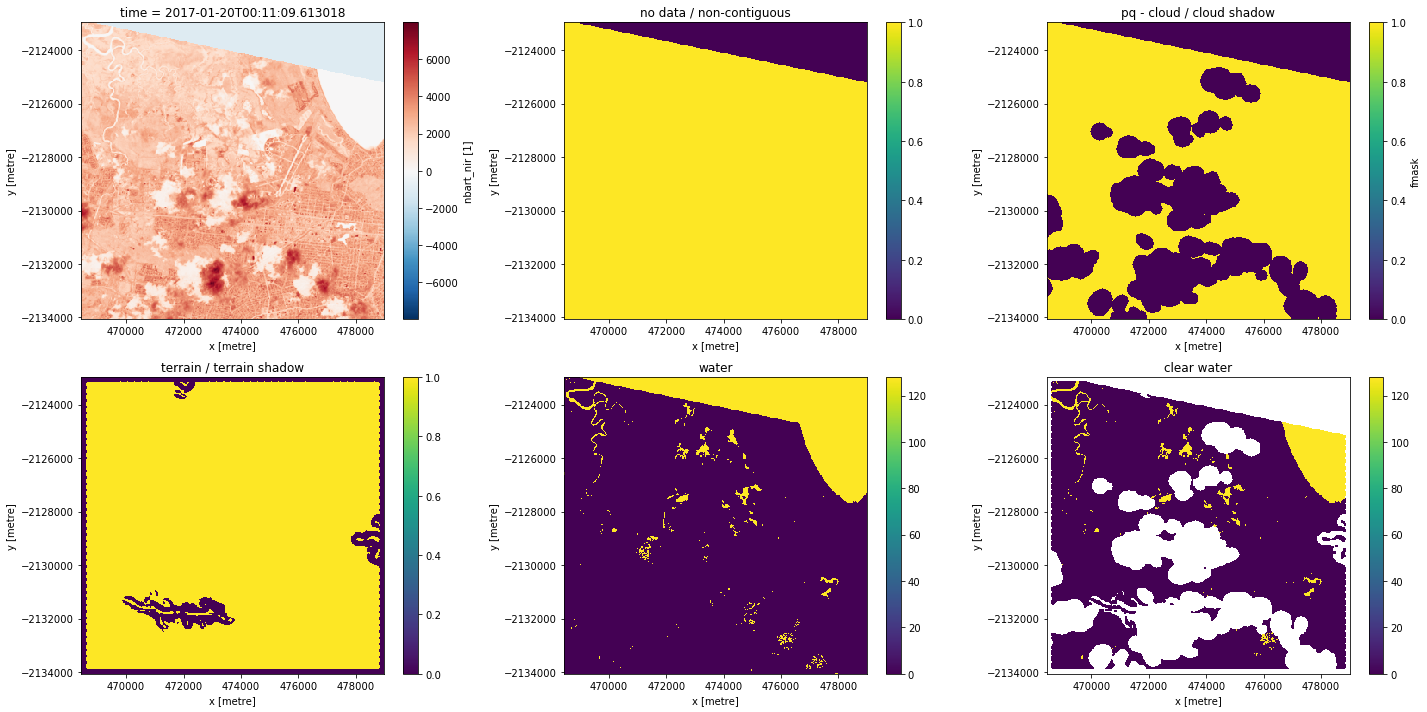

In [20]:
# crs:      EPSG:32655
# Show all masks, plus water and clear water
# no data/non-contiguous, pq - cloud/cloud shadow, terrain/terrain shadow

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,10))

ds.nbart_nir.plot(ax=axes[0,0])

f1.plot(ax=axes[0, 1])
axes[0, 1].set_title("no data / non-contiguous")

f2.plot(ax=axes[0, 2])
axes[0, 2].set_title("pq - cloud / cloud shadow")

tf.plot(ax=axes[1, 0])
axes[1, 0].set_title("terrain / terrain shadow")

water.plot(ax=axes[1,1])
axes[1, 1].set_title("water")

clear_water.plot(ax=axes[1,2])
axes[1, 2].set_title("clear water")

plt.tight_layout()
plt.draw()

## Reproject

## Compare

#### Load existing wofs tile

In [23]:
query2 = {'lon': (lon - buff, lon + buff),
         'lat': (lat - buff, lat + buff),
         'time': time_period}

curr_wofs = dc_prod.load(product='wofs_albers', 
                  output_crs=output_crs,
                  resolution=output_resolution, 
                  **query2,
                  align=c_align
                 )


In [38]:
curr_wofs=curr_wofs.isel(time=2)

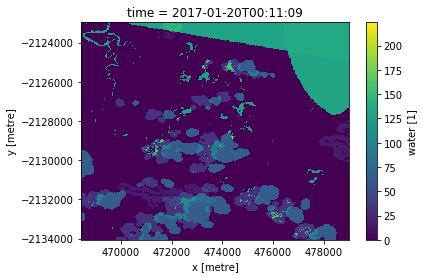

In [103]:
curr_wofs.water.plot()

In [41]:
wetWOFL = masking.make_mask(curr_wofs, wet = True)
dryWOFL = masking.make_mask(curr_wofs, dry = True)
cloudWOFL 

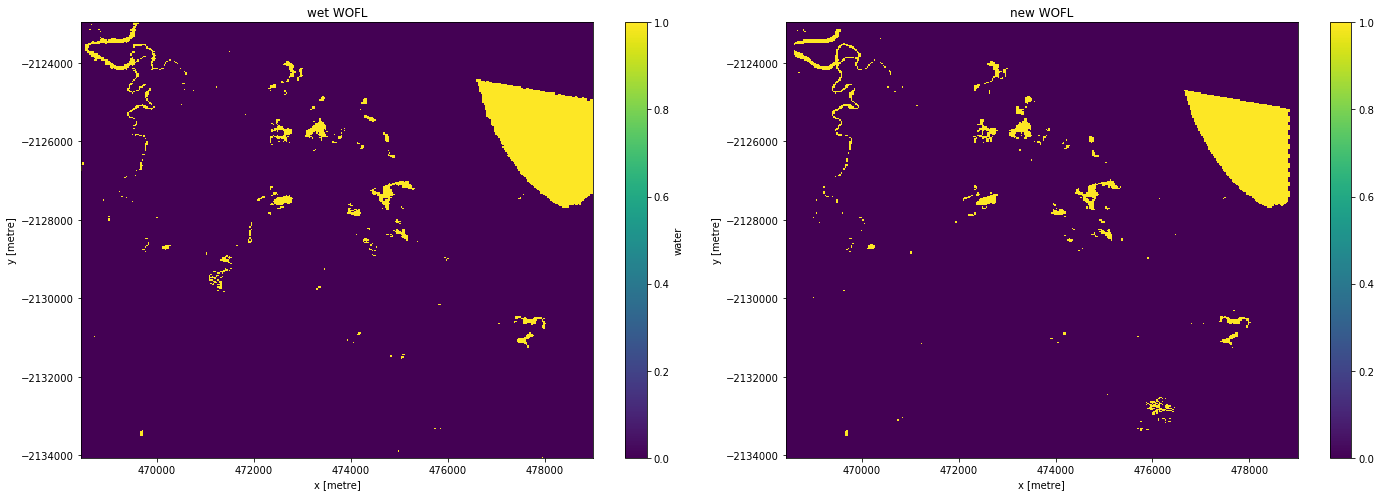

In [89]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

wetWOFL.water.plot(ax=axes[0])
newWOFL.plot(ax=axes[1])
axes[0].set_title("wet WOFL")
axes[1].set_title("new WOFL")

plt.tight_layout()
plt.draw()

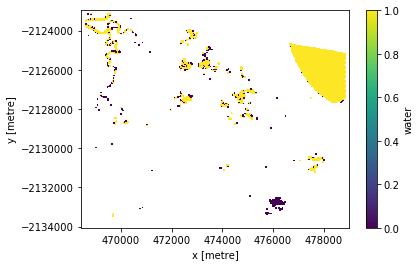

In [95]:
wetWOFL.water.where(newWOFL).plot()


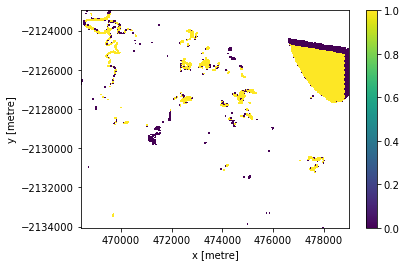

In [101]:
newWOFL.where(wetWOFL.water).plot()